# <center>Проект: Прогнозирование стоимости жилья</center>  
# <center>для агентства недвижимости</center>  
# <center>Часть 2</center>  


## 4. Построение модели 

На предыдущих этапах мы изучили бизнес-задачу познакомились с данными, произвели их очистку и частично приобразовали в числовой формат, пригодный для использования в машинном обучении. На этом этапе нам предстоит выбрать лучший алгоритм, настроить параметры и провести оценку (валидацию) модели. При необходимости мы будем возвращаться к нашим данным, чтобы дополнительно очистить их от выбросов или сгенерировать дополнительные признаки.

Для оценки модели будем использовать следующие метрики:

- `MAE` - средняя абсолютная ошибка - значение в долларах США
- `MAPE` - средняя абсолютная ошибка в процентах 
- `R2` - коэффициент детерминации - метрика указывает насколько хорошо модель уловила закономерности исходного набора данных


In [1]:
#!pip install category_encoders
#!pip install optuna
#!pip install geopy
#!pip install xgboost

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns

import missingno as msno
import sweetviz as sv
import matplotlib.pyplot as plt

import re
from datetime import datetime
from gmaps import Geocoding

import category_encoders as ce

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, chi2
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import Pipeline

from scipy.stats import shapiro

import geopy

import pickle

import geopy.distance

#from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

import xgboost as xgb


Определим функцию для рассчет целевых метрик

In [3]:
# Функция для расчета метрик и вывода на экран
def get_metrics(y_train, y_train_pred, y_test, y_test_pred, output=True):
    # Вычислим метрики тренингового набора
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    if output==True:
        print('\nMAE на тренировочоной выборке:', round(mae_train, 3))
        print('MAPE на тренировочной выборке:', round(mape_train, 3))
        print('r2 на тренировочоной выборке:', round(r2_train, 3))

    # Вычислим метрики тестового набора
    mae_test = mean_absolute_error(y_test, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    if output==True:
        print('\nMAE на тестовой выборке:', round(mae_test, 3))
        print('MAPE на тестовой выборке:', round(mape_test, 3))
        print('r2 на тестовой выборке:', round(r2_test, 3))

    
    return [mae_train, mape_train, r2_train, mae_test, mape_test, r2_test]

metrics_list = []


In [4]:
# загрузим данные, подготовленные на предыдущем этапе

with open('df.pkl', 'rb') as f:
    df = pickle.load(f) # deserialize using load()
  
# атрибуты для использования в модели
new_columns = [col for col in  df.columns if col.startswith('new_')]

# сделаем копию с колонками для дальнейшей работы и удалим исходный датафрейм их оперативной памяти

data = df[new_columns]

data.shape

(322923, 16)

In [5]:
# Выделим целевую переменную и предикторы
X = data.drop('new_target', axis=1)
y = data['new_target']


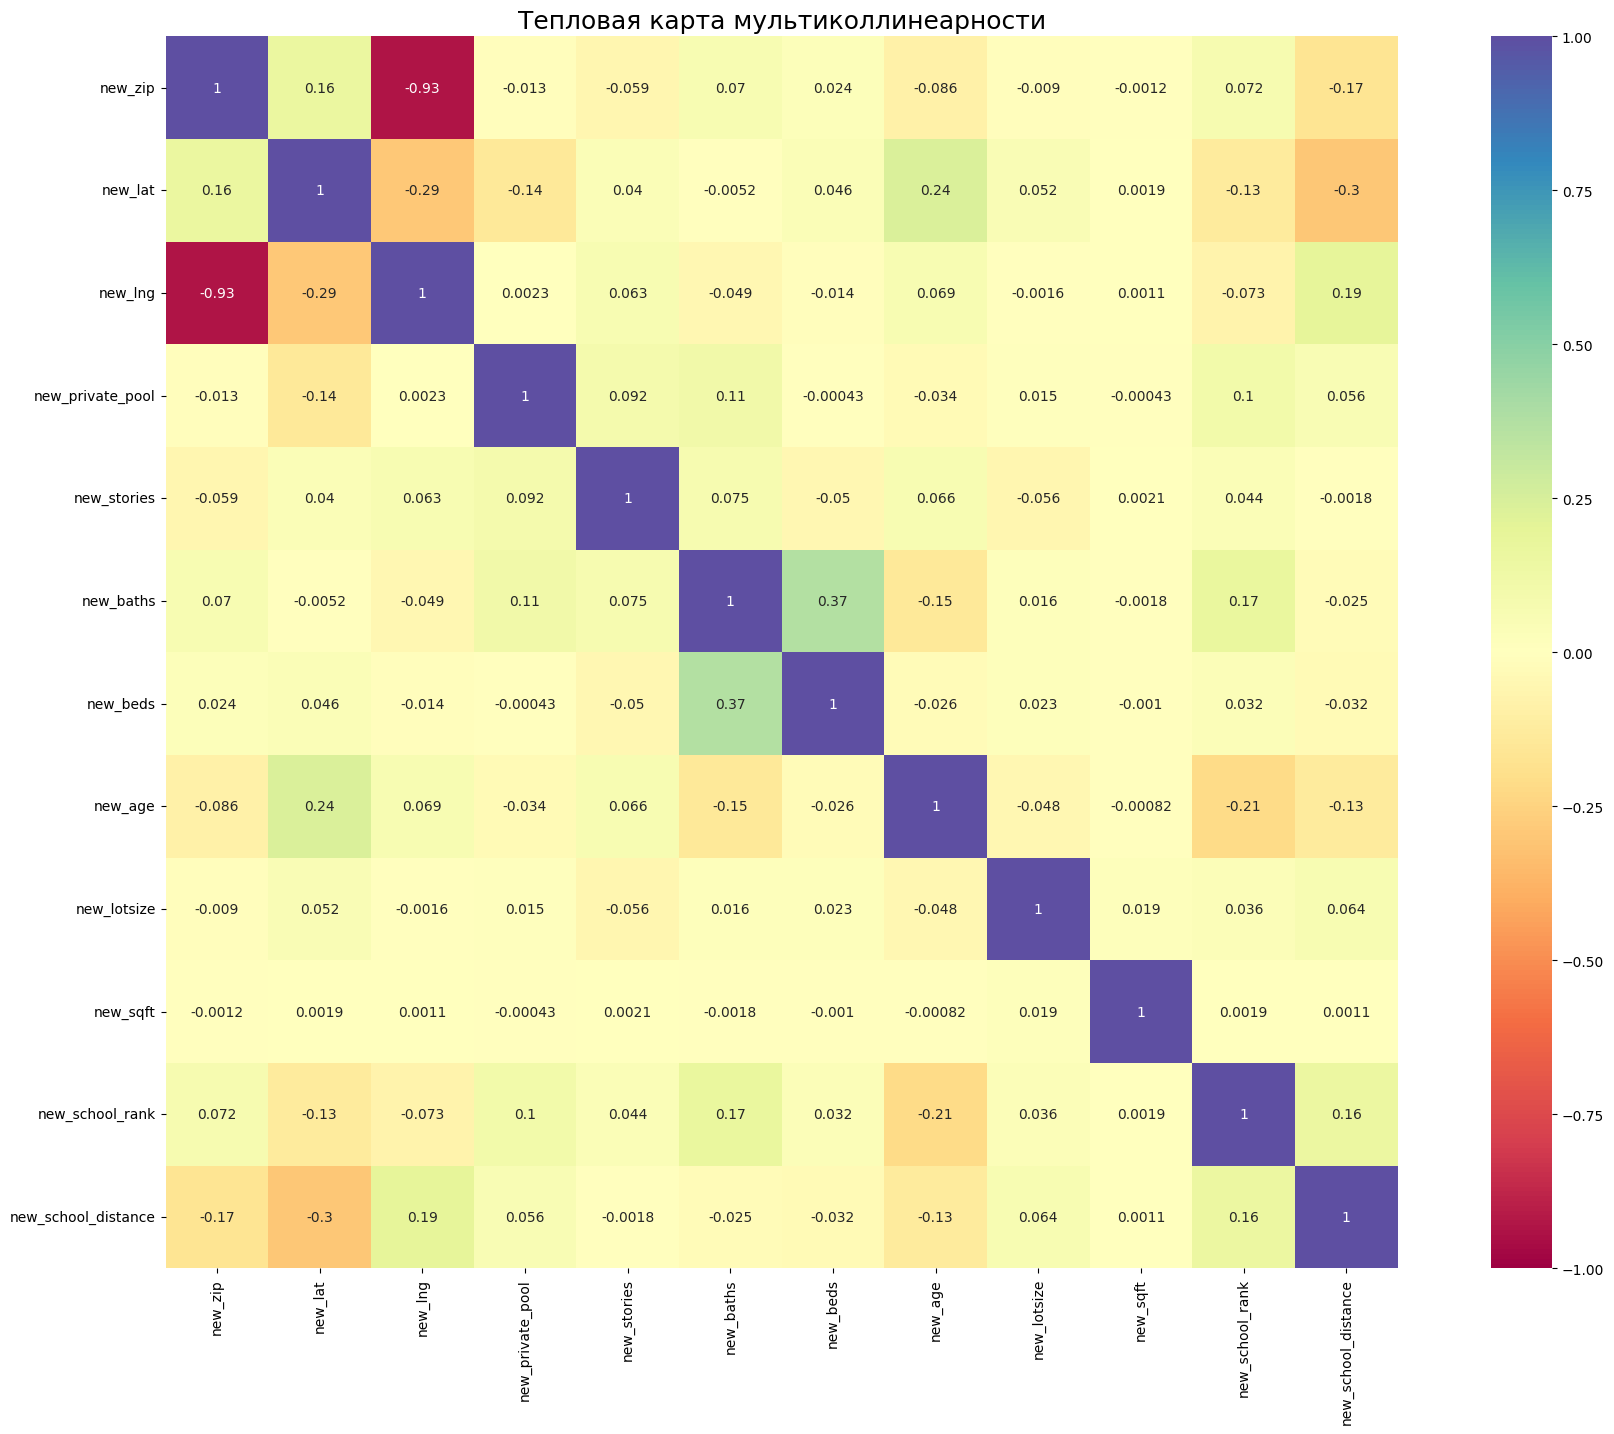

In [6]:
# Построим тепловую карту мультиколлинеарности
fig = plt.figure(figsize=(24, 16))
heatmap = sns.heatmap(
    data = X.corr(method='pearson', numeric_only=True),
    annot = True,
    fmt = '.2g',
    vmin = -1,
    vmax = 1,
    center = 0,
    cmap= 'Spectral',
    square = True
);
heatmap.set_title('Тепловая карта мультиколлинеарности', fontsize=18);

Атрибут new_lng имеет высокую степень корреляции с new_zip. 

In [7]:
# исключим new_lng из списка атрибутов используемых в модели
df.rename(columns={'new_lng':'lng'},inplace=True)

### 4.1. Baseline решение 

Категориальные переменные с количеством значений больше 10 будем кодировать бинарным кодированием, остальные onehot 

In [8]:
#  Количество уникальных категорий в оставшихся нечисловых признаках
print('Количество категорий: \n', data.select_dtypes(include='object').nunique())

Количество категорий: 
 new_state_id        34
new_status           4
new_propertyType     6
dtype: int64


In [9]:
# Разделим выборку на тренинговую и тестову
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(258338, 15) (64585, 15) (258338,) (64585,)


In [10]:
all_columns = [col for col in  X.columns if col.startswith('new_')]


binary_columns = ['new_state_id','new_status','new_propertyType']

numeric_columns = [col for col in all_columns if col not in binary_columns]


In [11]:
# making pipeline
# putting numeric columns to scaler and categorical to binary or onehot encoder``
scaler = RobustScaler()
binary_encoder = ce.BinaryEncoder(cols=binary_columns)

numeric_transformer = make_pipeline(scaler)

binary_transformer = make_pipeline(binary_encoder)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('numeric', numeric_transformer, numeric_columns),
                    ('binary', binary_transformer, binary_columns)
                    ])


# choosing model
model_name = LinearRegression()

# giving all values to pipeline
pipe = make_pipeline(preprocessor,model_name)
pipe.fit(X_train, y_train)

# make predictions on training set
y_train_pred = pipe.predict(X_train)

# make predictions on test set
y_test_pred = pipe.predict(X_test)

# рассчитаем и запомним метрики

metrics_list.append( ['baseline','df']+get_metrics(y_train,y_train_pred,y_test,y_test_pred))



MAE на тренировочоной выборке: 144821.623
MAPE на тренировочной выборке: 1.134
r2 на тренировочоной выборке: 0.261

MAE на тестовой выборке: 145754.356
MAPE на тестовой выборке: 1.108
r2 на тестовой выборке: 0.259


Вывод: Модель имеет значительную ошибку и не уловила особенностей выборки

## 4.2. Дальнейшая обработка данных 

### 4.2.1 Cгенерируем призак new_distance_to_capital (Расстояние до столицы штата по координатам почтового индекса)

In [12]:
states_df = pd.read_csv('states.csv')
states_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   state      52 non-null     object 
 1   latitude   52 non-null     float64
 2   longitude  52 non-null     float64
 3   name       52 non-null     object 
dtypes: float64(2), object(2)
memory usage: 1.8+ KB


In [13]:
# перенесем координаты столицы штата в исходный датафрейм 
df = df.merge(states_df[['state','latitude','longitude']], left_on='new_state_id',right_on='state', how='left', suffixes=['','_right'])


# в наборе были записи с кодом штата не США
df.dropna(subset=['latitude','longitude'],inplace = True)

# вычислим расстояния
df['new_distance_to_capital'] = df.apply(lambda row:geopy.distance.geodesic((row['new_lat'],row['lng']),(row['latitude'],row['longitude'] )).km, axis=1 )

df = df.drop(columns=['state_right','latitude','longitude'] )

### 4.2.1 Cгенерируем призаки new_P_Dencity и new_P_Income (Средняя плотность населения и средний доход по почтовому индексу)

Воспользуемся данными статистического управления США за 2022 год

In [14]:
income_df = pd.read_csv('income-2022/Income_Data.csv',skiprows=1,)[['Geographic Area Name','Estimate!!Households!!Total','Estimate!!Households!!Mean income (dollars)']]
income_df.rename({'Geographic Area Name':'ZCTA5','Estimate!!Households!!Total':'n_households','Estimate!!Households!!Mean income (dollars)':'mean_income'},axis=1,inplace=True)

In [15]:
# выделим почтовый индекс из кода территории и преобразуем в числовой формат
income_df['ZCTA5'] = income_df['ZCTA5'].apply(lambda x : float(x.split()[1]))

In [16]:
# объединим с исходным файлом
df = df.merge(income_df, left_on='new_zip',right_on='ZCTA5',how='left')
df = df.drop(columns=['ZCTA5'] )
df = df.rename( columns={'n_households':'new_n_households','mean_income':'new_mean_income'})


In [17]:
# функция преобразует строку в переменную float и заменяет запятые на точку
def string_to_float(x):
    if isinstance(x, (int, float)):
        return x 
    if (x is not np.NaN) and (x is not None):
        x_list = re.findall(r'\d+\.*,*\d*', x)
        if len(x_list) > 0:
            return float(x_list[0].replace(',', '') )        

df.new_mean_income = df['new_mean_income'].apply(string_to_float)
df.new_n_households = df['new_n_households'].apply(string_to_float)

In [18]:
# количество отсутствующих значения
print(len(df[df['new_mean_income'].isnull()==True]),len(df[df['new_n_households'].isnull()==True]))


25 8


In [19]:
# заполняем пустые значения медианным по штатам в каждой категории
df['new_mean_income'] = df['new_mean_income'].fillna(df.groupby(['new_state_id','new_propertyType'])['new_mean_income'].transform('median'))
df['new_n_households'] = df['new_n_households'].fillna(df.groupby(['new_state_id','new_propertyType'])['new_n_households'].transform('median'))
print('Количество неопределенных значений =',df['new_mean_income'].isnull().sum())
print('Количество неопределенных значений =',df['new_n_households'].isnull().sum())

Количество неопределенных значений = 0
Количество неопределенных значений = 0


In [20]:
# сохраним расширенный датафрейм для последующего использования
# Save df to a file
#with open('web/app/data/df_extended.pkl', 'wb') as file:
#    pickle.dump(df, file)

## 4.3. Baseline 2 (с дополнительными колонками)

In [21]:
# Выделим целевую переменную и предикторы
X = df.drop('new_target', axis=1)
y = df['new_target']
# Разделим выборку на тренинговую и тестову
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(258335, 46) (64584, 46) (258335,) (64584,)


In [22]:
# making pipeline

all_columns = [col for col in  X.columns if col.startswith('new_')]


binary_columns = ['new_state_id','new_status','new_propertyType']

numeric_columns = new_columns = [col for col in all_columns if col not in binary_columns]

# putting numeric columns to scaler and categorical to binary or onehot encoder``
scaler = RobustScaler()
binary_encoder = ce.BinaryEncoder(cols=binary_columns)

numeric_transformer = make_pipeline(scaler)
binary_transformer = make_pipeline(binary_encoder)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('numeric', numeric_transformer, numeric_columns),
                    ('binary', binary_transformer, binary_columns)
                    ])


# choosing model
model_name = LinearRegression()

# giving all values to pipeline
pipe = make_pipeline(preprocessor,model_name)
pipe.fit(X_train, y_train)

# make predictions on training set
y_train_pred = pipe.predict(X_train)

# make predictions on test set
y_test_pred = pipe.predict(X_test)

# рассчитаем и запомним метрики

metrics_list.append( ['baseline-2','+ income,capital']+get_metrics(y_train,y_train_pred,y_test,y_test_pred))


MAE на тренировочоной выборке: 133717.514
MAPE на тренировочной выборке: 1.014
r2 на тренировочоной выборке: 0.331

MAE на тестовой выборке: 134124.391
MAPE на тестовой выборке: 1.012
r2 на тестовой выборке: -0.887


In [23]:
pd.options.display.max_colwidth = None
pd.options.display.float_format = '{:,.4f}'.format
pd.DataFrame(metrics_list, columns=['Model','Data','train MAE','train MAPE','train R2','test MAE','test MAPE','test R2'])

,Model,Data,train MAE,train MAPE,train R2,test MAE,test MAPE,test R2
0,baseline,df,"144,821.6229",1.1344,0.2607,"145,754.3556",1.1083,0.2591
1,baseline-2,"+ income,capital","133,717.5139",1.0143,0.3311,"134,124.3906",1.0116,-0.8867


### 4.4. Модель линейной регрессии с полиномиальными признаками 2-го порядка

Получим результат для сравнения с другими моделями

In [24]:
# Выделим целевую переменную и предикторы
all_columns = [col for col in  df.columns if col.startswith('new_')]
X = df[all_columns].drop('new_target', axis=1)
y = df['new_target']

# Создаем объект класса PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)

binary_columns = ['new_state_id','new_status','new_propertyType']
binary_encoder = ce.BinaryEncoder(cols=binary_columns)

X = binary_encoder.fit_transform(X)

# Генерируем полиномиальные признаки
X_poly = poly.fit_transform(X)

# Разделим выборку на тренинговую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X_poly, y,
                                                    test_size=0.2,
                                                    random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


# choosing model
model = LinearRegression()
model.fit(X_train, y_train)

# make predictions on training set
y_train_pred = model.predict(X_train)

# make predictions on test set
y_test_pred = model.predict(X_test)

# рассчитаем и запомним метрики

metrics_list.append( ['Polinomial','2 degree']+get_metrics(y_train,y_train_pred,y_test,y_test_pred))

(258335, 377) (64584, 377) (258335,) (64584,)

MAE на тренировочоной выборке: 110673.559
MAPE на тренировочной выборке: 0.766
r2 на тренировочоной выборке: 0.524

MAE на тестовой выборке: 7064192.838
MAPE на тестовой выборке: 35.886
r2 на тестовой выборке: -61736747.848


In [25]:
pd.DataFrame(metrics_list, columns=['Model','Data','train MAE','train MAPE','train R2','test MAE','test MAPE','test R2'])

,Model,Data,train MAE,train MAPE,train R2,test MAE,test MAPE,test R2
0,baseline,df,"144,821.6229",1.1344,0.2607,"145,754.3556",1.1083,0.2591
1,baseline-2,"+ income,capital","133,717.5139",1.0143,0.3311,"134,124.3906",1.0116,-0.8867
2,Polinomial,2 degree,"110,673.5593",0.7661,0.5245,"7,064,192.8383",35.8859,"-61,736,747.8480"


Модель baseline-2 не может объяснить добавленные признаки. Хотя MAPE улучшился в обоих тренинговой и тестовой выборках R2 в тестовой катострофически упал. Очевидно, линейная регрессия недостаточно сложная модель.
Модель полиномиальной регрессии показывает сильное переобучение. R2 на обучающей выборке значительно вырос, но на тестовой значительно упал. Мы также видим, что ошибка на тестовой выборке составляет почти 30%, модель неприемлема.

## 4.6. XGBRegressor 

In [26]:
# Выделим целевую переменную и предикторы
X = df.drop('new_target', axis=1)
y = df['new_target']
# Разделим выборку на тренинговую и тестову
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(258335, 46) (64584, 46) (258335,) (64584,)


In [27]:
%%time
# making pipeline

all_columns = [col for col in  X.columns if col.startswith('new_')]

binary_columns = ['new_state_id','new_status','new_propertyType']

numeric_columns = [col for col in all_columns if col not in binary_columns]


# putting numeric columns to scaler and categorical to binary or onehot encoder``
scaler = RobustScaler()
binary_encoder = ce.BinaryEncoder(cols=binary_columns)

numeric_transformer = make_pipeline(scaler)

binary_transformer = make_pipeline(binary_encoder)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('numeric', numeric_transformer, numeric_columns)              
                    ,('binary', binary_transformer, binary_columns)
                    ])

# choosing model

estimator = xgb.XGBRegressor()

param_grid = {
    'xgb__max_depth': [7,10, 13], # влияет как на производительность так и на метрики
    'xgb__n_estimators': [100,250,500], # параметр значительно влияет на производительность модели в экплуатации
    'xgb__lambda':[None,0.005] # возможно переобучение - попробуем регуляризацию
}


# giving all values to pipeline

pipe = Pipeline([('pre', preprocessor),
                 ('xgb', estimator)])

model = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, refit=True,scoring='r2', verbose=1)


model.fit(X_train,y_train)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
CPU times: user 2min 13s, sys: 23.7 s, total: 2min 37s
Wall time: 4min 41s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('robustscaler',
                                                                                          RobustScaler())]),
                                                                         ['new_zip',
                                                                          'new_lat',
                                                                          'new_private_pool',
                                                                          'new_stories',
                                                                          'new_baths',
                                                                          'new_beds',
                                                                          'new_age',
                                                                          'new_lotsize',
                                                                          'new_sqft',
                                                                          'new_school_rank',
                                                                          'new_school_distance',
                                                                          'new_distance_to_capital',
                                                                          'new_n_households',
                                                                          'new_mean...
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__lambda': [None, 0.005],
                         'xgb__max_depth': [7, 10, 13],
                         'xgb__n_estimators': [100, 250, 500]},
             scoring='r2', verbose=1)

In [28]:
# make predictions on training set
y_train_pred = model.predict(X_train)

# make predictions on test set
y_test_pred = model.predict(X_test)

# рассчитаем и запомним метрики
metrics_list.append( ['GridSearchCV: XGBRegressor',[all_columns]]+get_metrics(y_train,y_train_pred,y_test,y_test_pred))


MAE на тренировочоной выборке: 18082.634
MAPE на тренировочной выборке: 0.111
r2 на тренировочоной выборке: 0.982

MAE на тестовой выборке: 54469.931
MAPE на тестовой выборке: 0.308
r2 на тестовой выборке: 0.839


In [29]:
print('Best_params: ',model.best_params_)

Best_params:  {'xgb__lambda': None, 'xgb__max_depth': 10, 'xgb__n_estimators': 500}


Вывод:  Получен хороший результат, модель хорошо уловила зависимости в трениговом наборе но к сожалению показывает признаки переобучения. Мы пробовали избавиться от переобучения добавив регуляризацию в сетку параметров или сократив глубину деревьев. При этом лучший результат по версии GridsechCV:  'lambda': None, 'max_depth': 10, 'n_estimators': 500, то есть сокращение глубины деревьев оказалось полезным, а включение регуляризации не улучшило модель.

Большое количество параметров модели, особенно если требуется ручной ввод, может существенно усложнить внедрение модели в эксплуатацию. 
Прежде чем приступить к формирования pipeline для эксплуатации, попробуем оценить важность признаков и отследить влияние количества признаков на метрики качества модели.

К сожалению в процессе подготовки данных в pipeline для GridsechCV порядок и имена признаков не сохранились, поэтому для определения важности признаков воспользуемся кодом без использования pipeline.

In [30]:
def test_feature_importance(all_columns):
    

#    binary_columns = ['new_state_id','new_status','new_propertyType']
#    numeric_columns = [col for col in all_columns if col not in binary_columns+['new_target']]

    X = df[all_columns]

# Выделим целевую переменную и предикторы

    y = X['new_target']
    X = X.drop('new_target', axis=1)

    binary_columns = X.select_dtypes('object').columns.to_list()
#    print('Binary=',binary_columns)
    if len(binary_columns) >0:
        binary_encoder = ce.BinaryEncoder(cols=binary_columns)
        X = binary_encoder.fit_transform(X)

    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)

# Разделим выборку на тренинговую и тестовую
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    test_size=0.2,
                                                    random_state=42)

#    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


    # choosing model
    model_name = xgb.XGBRegressor(max_depth = model.best_params_['xgb__max_depth']
                              , n_estimators = model.best_params_['xgb__n_estimators']
                              , enable_categorical = True
                              )

    model_name.fit(X_train,y_train)

# make predictions on training set
    y_train_pred = model_name.predict(X_train)

# make predictions on test set
    y_test_pred = model_name.predict(X_test)

# рассчитаем и запомним метрики

    metrics =  [f'XGBRegressor.feature_importance_:{all_columns}',len(all_columns)-1]+get_metrics(y_train,y_train_pred,y_test,y_test_pred, output=False)

    return X, model_name.feature_importances_, metrics

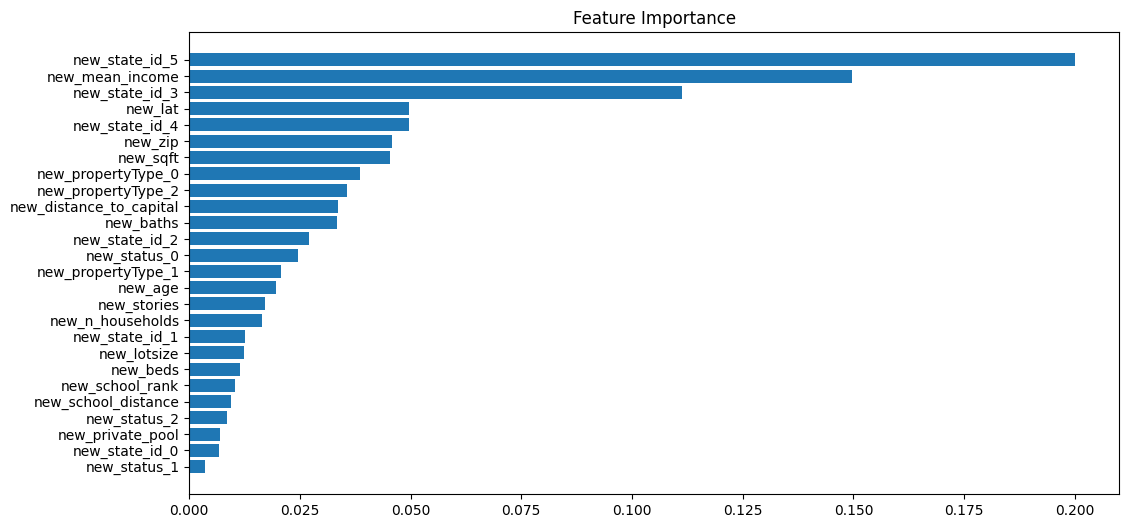

In [31]:
all_columns = [col for col in  df.columns if col.startswith('new_')]
X, feature_importance, metrics = test_feature_importance(all_columns)
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance');


In [32]:
np.array(X.columns)[sorted_idx]

array(['new_status_1', 'new_state_id_0', 'new_private_pool',
       'new_status_2', 'new_school_distance', 'new_school_rank',
       'new_beds', 'new_lotsize', 'new_state_id_1', 'new_n_households',
       'new_stories', 'new_age', 'new_propertyType_1', 'new_status_0',
       'new_state_id_2', 'new_baths', 'new_distance_to_capital',
       'new_propertyType_2', 'new_propertyType_0', 'new_sqft', 'new_zip',
       'new_state_id_4', 'new_lat', 'new_state_id_3', 'new_mean_income',
       'new_state_id_5'], dtype=object)

In [33]:
# расположим имена признаков в порядке убывания важности
best_columns = ['new_target']

for column in np.array(X.columns)[sorted_idx][::-1]:
     for name in all_columns:
        if column.startswith(name) and (name not in best_columns):
            best_columns.append(name)
            break
# получим занчения метрик для разного количества наиболее важных признаков

#print(best_columns)

importance_test_metrics = []

for i in range(2,len(best_columns)):
    _,_,metrics = test_feature_importance(best_columns[:i])

    importance_test_metrics.append(metrics)

In [34]:
pd.options.display.max_colwidth = None
pd.DataFrame(importance_test_metrics, columns=['Model','Data','train MAE','train MAPE','train R2','test MAE','test MAPE','test R2'])

,Model,Data,train MAE,train MAPE,train R2,test MAE,test MAPE,test R2
0,"XGBRegressor.feature_importance_:['new_target', 'new_state_id']",1,"162,786.1728",1.3746,0.1286,"162,311.1063",1.3728,0.1333
1,"XGBRegressor.feature_importance_:['new_target', 'new_state_id', 'new_mean_income']",2,"128,365.9173",0.9515,0.4025,"128,795.6277",0.9556,0.3966
2,"XGBRegressor.feature_importance_:['new_target', 'new_state_id', 'new_mean_income', 'new_lat']",3,"122,298.9248",0.8641,0.4472,"123,703.0014",0.8740,0.4330
3,"XGBRegressor.feature_importance_:['new_target', 'new_state_id', 'new_mean_income', 'new_lat', 'new_zip']",4,"122,023.7190",0.8587,0.4493,"123,462.3040",0.8677,0.4349
4,"XGBRegressor.feature_importance_:['new_target', 'new_state_id', 'new_mean_income', 'new_lat', 'new_zip', 'new_sqft']",5,"48,742.5728",0.3273,0.8670,"69,381.3063",0.4272,0.7576
5,"XGBRegressor.feature_importance_:['new_target', 'new_state_id', 'new_mean_income', 'new_lat', 'new_zip', 'new_sqft', 'new_propertyType']",6,"42,787.4252",0.2768,0.8932,"66,205.0682",0.3844,0.7753
6,"XGBRegressor.feature_importance_:['new_target', 'new_state_id', 'new_mean_income', 'new_lat', 'new_zip', 'new_sqft', 'new_propertyType', 'new_distance_to_capital']",7,"42,245.1971",0.2739,0.8945,"65,687.9917",0.3819,0.7766
7,"XGBRegressor.feature_importance_:['new_target', 'new_state_id', 'new_mean_income', 'new_lat', 'new_zip', 'new_sqft', 'new_propertyType', 'new_distance_to_capital', 'new_baths']",8,"39,687.4471",0.2629,0.9051,"65,583.1911",0.3807,0.7814
8,"XGBRegressor.feature_importance_:['new_target', 'new_state_id', 'new_mean_income', 'new_lat', 'new_zip', 'new_sqft', 'new_propertyType', 'new_distance_to_capital', 'new_baths', 'new_status']",9,"39,105.4187",0.2590,0.9073,"65,834.7560",0.3807,0.7806
9,"XGBRegressor.feature_importance_:['new_target', 'new_state_id', 'new_mean_income', 'new_lat', 'new_zip', 'new_sqft', 'new_propertyType', 'new_distance_to_capital', 'new_baths', 'new_status', 'new_age']",10,"29,895.3488",0.2175,0.9361,"59,147.4495",0.3546,0.8110


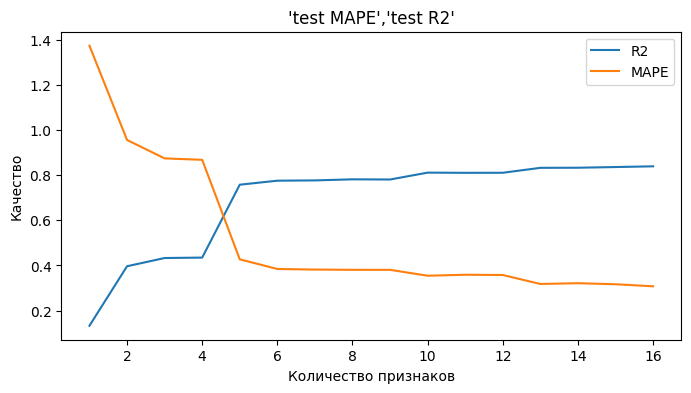

In [35]:
# Построим график зависимости метрик тестовой выборки от количества лучших признаков

metrics_df = pd.DataFrame(importance_test_metrics, columns=['Model','Data','train MAE','train MAPE','train R2','test MAE','test MAPE','test R2'])

#print(metrics_df)

fig = plt.figure(figsize=(8, 4))
lineplot = sns.lineplot(

    x = metrics_df['Data'],
    y = metrics_df['test R2'],
    legend='auto',
    label = 'R2'
);
lineplot = sns.lineplot(
    x = metrics_df['Data'],
    y = metrics_df['test MAPE'],
    legend = 'auto',
    label = 'MAPE',
);
lineplot.set_title("'test MAPE','test R2'");
lineplot.set_ylabel('Качество');
lineplot.set_xlabel('Количество признаков');
lineplot.legend();


In [36]:
# выберем количество лучших признаков 
n=13

print('Признаки    вошедшие в {} лучших:{}'.format(n,best_columns[1:n+1]),
      '\nПризнаки НЕ вошедшие лучшие:',best_columns[n+1:])

best_features = best_columns[1:n+1]

Признаки    вошедшие в 13 лучших:['new_state_id', 'new_mean_income', 'new_lat', 'new_zip', 'new_sqft', 'new_propertyType', 'new_distance_to_capital', 'new_baths', 'new_status', 'new_age', 'new_stories', 'new_n_households', 'new_lotsize'] 
Признаки НЕ вошедшие лучшие: ['new_beds', 'new_school_rank', 'new_school_distance', 'new_private_pool']


Из графика можно сделать, что качество модели растет до 13 лучших признаков и затем практически не улучшается. Это означает, что для практических целей достаточно оставить модель с 13 признаками. Мы не удивлены, что признак наличия бассейна влияет на предсказание наименьшим образом, но отсутствие таких признаков как рейтинг школы, расстояние до школы, количеcтво спальных комнат в списке лучших противоречит интуиции. Возможны следующие объяснения полученных результатов. Сгенерированные признаки на основе данных статистики: средний доход и расстояние до столицы - лучше объясняют цену недвижимости в территории почтового индекса. Признак наличие бассейна имел большое количество пропусков. 

In [37]:
# making pipeline


#all_columns = [col for col in  df.columns if col.startswith('new_')]

all_columns = best_features+['new_target']


X = df[all_columns]
binary_columns = X.select_dtypes('object').columns.to_list()
numeric_columns = [col for col in all_columns if col not in binary_columns+['new_target']]

# Выделим целевую переменную и предикторы
y = X['new_target']
X = X.drop('new_target', axis=1)

binary_encoder = ce.BinaryEncoder(cols=binary_columns)
scaler = RobustScaler()

# Разделим выборку на тренинговую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


# putting numeric columns to scaler and categorical to binary encoder

scaler = RobustScaler()
numeric_transformer = make_pipeline(scaler)
binary_transformer = make_pipeline(binary_encoder)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[    ('binary', binary_transformer, binary_columns),
                        ('numeric', numeric_transformer, numeric_columns)
                    ])


# choosing model
model_name = xgb.XGBRegressor(max_depth = model.best_params_['xgb__max_depth']
                              , n_estimators = model.best_params_['xgb__n_estimators']
                              , enable_categorical = True
                              )

# giving all values to pipeline
pipe = make_pipeline(preprocessor,model_name)
pipe.fit(X_train, y_train)

# make predictions on training set
y_train_pred = pipe.predict(X_train)

# make predictions on test set
y_test_pred = pipe.predict(X_test)

# рассчитаем и запомним метрики
metrics_list.append( ['XGBRegressor-production',str(len(best_features))+' best features']+get_metrics(y_train,y_train_pred,y_test,y_test_pred))

(258335, 13) (64584, 13) (258335,) (64584,)

MAE на тренировочоной выборке: 22537.131
MAPE на тренировочной выборке: 0.149
r2 на тренировочоной выборке: 0.965

MAE на тестовой выборке: 55069.569
MAPE на тестовой выборке: 0.316
r2 на тестовой выборке: 0.834


In [38]:
pd.DataFrame(metrics_list, columns=['Model','Data','train MAE','train MAPE','train R2','test MAE','test MAPE','test R2'])

,Model,Data,train MAE,train MAPE,train R2,test MAE,test MAPE,test R2
0,baseline,df,"144,821.6229",1.1344,0.2607,"145,754.3556",1.1083,0.2591
1,baseline-2,"+ income,capital","133,717.5139",1.0143,0.3311,"134,124.3906",1.0116,-0.8867
2,Polinomial,2 degree,"110,673.5593",0.7661,0.5245,"7,064,192.8383",35.8859,"-61,736,747.8480"
3,GridSearchCV: XGBRegressor,"[[new_zip, new_state_id, new_lat, new_status, new_private_pool, new_stories, new_propertyType, new_baths, new_beds, new_age, new_lotsize, new_sqft, new_school_rank, new_school_distance, new_distance_to_capital, new_n_households, new_mean_income]]","18,082.6344",0.1113,0.9823,"54,469.9306",0.3079,0.8394
4,XGBRegressor-production,13 best features,"22,537.1309",0.1489,0.9654,"55,069.5685",0.3159,0.8340


In [39]:
# сохраним расширенный датафрейм для последующего использования в веб сервисе
# Save df to a file
with open('web/app/data/df.pkl', 'wb') as file:
    pickle.dump(df[all_columns].sample(frac=0.1), file)

In [40]:
# Save the model to a file
with open('web/app/models/XGBRegressor-pipe.pkl', 'wb') as file:
    pickle.dump(pipe, file)

In [41]:
!pip freeze > requirements.txt

 Выводы по проекту  

1. В соответствие с CRISP-DM было произведено:
 - Исследование бизнес-целей (Business Understanding)
 - Начальное изучение данных (Data Understanding)
 - Подготовка данных (Data Preparation)
 - Моделирование (Modeling)
 - Оценка (Evaluation)
 - Внедрение (Deployment)

Потребовалось несколько итераций шагов CRISP-DM по результатам оценки моделирования. В процессе этой работы были проведены очистка данных и создание новые признаков, выбор модели и оптимизация параметров модели. Мы получили модель с высокой степенью усвоения закономерностей представленных в исходных данных, о чем свидетельствует критерий R2=0.8340. В этом можно убедиться протестировав построенный сервис в веб-форме, вручную изменяя параметры и наблюдая за реакцией модели. 

В рабочей модели можно надеятся на получение результатов с усредненной ошибкой до 0.32%. Нужно учесть, что этот параметр не означает, что каждая оценка будет произведена с точностью до 0,32%, но позволяет надеятся что совокупно по серии сделок оценка будет улучшена.

Дальнейшее совершенствование модели может включать лучшую подготовку исходных данных (например, выяснение причин попадания данных по аренде), создание дополнительных признаквв, таких как близость торговых центров, транспортных узлов и тп. на основе геолокации.

Возможно применение других алгоритмов, таких как нейронные сети также могло бы дать дополнительное улучшение качества модели, но вряд ли это будет приоритетом, при отсутствии более чистых данных и дополнительных источников информации. 

Для развертывания (Deployment) модели см. инструкцию в readme.md

Данный проект состоит из двух ноутбуков и проверочных файлов, полученных из открытых источников. Лицензии на использование эти данных можно проверить по ссылкам приведенным ниже. Для корректной работы ноутбуков zip-файлы необходимо развернуть от в соответсвующих поддиректориях:
    real_estate_price_part1.ipynb
    real_estate_price_part2.ipynb
    simplemaps_uszips_basicv1.84.zip   https://simplemaps.com/license
    income-2022.zip                    https://data.census.gov/table/ACSST1Y2022.S1901
    states.csv
